### Import libraries

In [66]:
import torch
import torch.nn as nn
from torch import optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import IterableDataset, TensorDataset, DataLoader, random_split

from models import peakyfinder_0006
from training.libs_train import train_loop, test_loop, Custom_Wgt_MSE
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from scipy.special import voigt_profile as voigt
import pickle
from pathlib import Path
import datetime

### Set paths

In [6]:
top_dir = Path.cwd()
datapath = top_dir

## PeakyMaker

In [7]:
class spectrum_maker():
    #class docstring, parameters, public methods
    """ generates LIBS spectra """
    #class attributes
    def __init__(self) -> None:
        self.elem = ['H', 'He', #row1
                    'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', #row2
                    'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', #row3
                    'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', #row4
                    'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', #row5
                    'Cs', 'Ba', #row6 alkali/alkaline earth
                    'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', #row6 rare earths
                    'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', #row6 transition metals
                    'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U'] #row 7 stable elements
        #random generator
        rng = np.random.default_rng()

        #database missing data for these elements
        with open(datapath / "rel_int/no_lines26.pickle", 'rb') as f:
            self.no_lines = pickle.load(f)
        
        # double check that no_lines elements aren't in avail_el
        self.elements = [el for el in self.elem if el not in self.no_lines]
        self.max_z = len(self.elements)
        with open(datapath / "rel_int/el_lines92.pickle", 'rb') as f:
            self.atom_dict = pickle.load(f)

        #relative natural abundance of elements
        self.elem_abund = np.loadtxt(datapath / "abundance/abundance_92.csv")


    # Peak maker function
    def peak_maker(self,
                    element, #element symbol for which spectrum will be generated
                    inc=1/30, #spectral wavelength resolution, i.e., increment between datapoints (nm)
                    w_lo=180, #lower limit of wavelength range (nm)
                    w_hi=961+(1/30), #upper limit of wavelength range (nm) - need an extra `inc` here to span full range
                    voigt_sig=0.5, #stdev of normal part of voigt convolution
                    voigt_gam=0.5, #half-width at half max parameter of cauchy part of convolution
                    temp=12000, # K
                    ne=10**17, # cm**-3 - electron density
                    shift=False,
                    shift_type='random',
                    shift_mean=2,
                    height=False,
                    height_type='random',
                    height_mag=2,
                    plot=False):
        """peak_maker generates a single-element LIBS spectrum for `element`
            args:
                element (str) - element symbol for which spectrum will be generated
            kwargs:
                inc (float) - spectral wavelength resolution, i.e., increment between datapoints (nm)
                w_lo (float) - lower limit of wavelength range (nm)
                w_hi (float) - upper limit of wavelength range (nm)
                voigt_sig (float) - stdev of normal part of voigt peak profile
                voigt_gam (float) - half-width at half max parameter of cauchy part of convolution
                temp (float) - temperature of plasma from which LIBS spectrum for this element is generated in (K)
                ne (float) - number density of electrons in the plasma (cm**-3)
                shift (bool) - whether to apply a shift to peak positions
                shift_type (str) - 'random' applies a random shift to each peak; 'sys' applies a systematic shift
                height (bool) - whether to jitter peak heights
                height_type (str) - 'random' jitters peak heights randomly
                height_mag (float) - maximum magnitude by which to vary peak heights
                plot (bool) - whether to plot the resulting spetrum
        """
        # ['sp_num', 'ritz_wl_vac(nm)', 'intens', 'gA(s^-1)', 'Ei(eV)', 'Ek(eV)','conf_i', 'term_i', 'J_i', 'conf_k', 'term_k', 'J_k', 'g_i', 'g_k'] # 14 total columns
        ionization = self.atom_dict[element][:,0].astype(float)
        peak_loc = self.atom_dict[element][:,1].astype(float)
        intens = self.atom_dict[element][:,2].astype(float)
        gA = self.atom_dict[element][:,3].astype(float)
        Ei = self.atom_dict[element][:,4].astype(float)
        Ek = self.atom_dict[element][:,5].astype(float)
        gi = self.atom_dict[element][:,12].astype(float)
        gk = self.atom_dict[element][:,13].astype(float)
        wave = np.arange(w_lo, w_hi, inc)
        
        def saha_boltzmann(peak_loc, intens, gA, gi, gk, Ei, Ek, temp=temp):
            """ apply saha boltzmann equation for a given set of peaks associated with element specified in parent 'peak_maker' function
                 args:
                    peak_loc (float) - Ritz wavelength (in nm)
                    gA (float) - Einstein transition probability for k->i transition multiplied by degeneracy of level k
                    gi (float) - degeneracy of the lower level i
                    gk (float) - degeneracy of upper level k
                    del_E (float) - energy difference between levels
                    T (float) - temperature of plasma (defauls to specification in peak_maker parent function)
                returns:
                    peak intensities at each transition wavelength

                supporting information:
                    https://www.nist.gov/pml/atomic-spectroscopy-compendium-basic-ideas-notation-data-and-formulas/atomic-spectroscopy
                    eline = (1/4pi) * hc/l * Aki * Nk
                    h is Planck constant - 6.62607015 * 10**-34
                    l is photon wavelength
                    Aki is atomic transition probability from k to i
                    Nk is the number density of ions in the upper level k
                        Nk is given by Saha-Boltzmann equation
                        Nk = Ni/Ne * gk/gi * Exp [-dEki/kT]
                            Ne is the total electron density
                            Ni is the density in the ith state
                            gk and gi are degeneracies of the levels k and i, respectively
                            dEki is the energy difference between levels k and i, respectively
                            k is Boltzmann constant (8.617333262*10**5 eV/K)
                            # 1 eV = 8065.54445(69) cm**-1
            """

            # calculate the partition functions to determine ion densities
            k = 8.617333262*10**-5 # eV/K
            kT = k*temp
            c = 3*10**8
            states = np.sort(np.unique(ionization))
            Zind = []
            for i in states:
                idx = ionization == i
                Zind.append(idx)
            Zi = []
            for i in Zind:
                Zie = gk[i] * np.exp(-Ek[i]/(kT))
                Zisum = np.sum(Zie, axis=0)
                Zi.append(Zisum)
            Zi = np.array(Zi) 
            #Zvals = Zi > 10**-10

            loc = []
            spec = []
            for i, z in enumerate(Zind):
                saha_spec = (4*np.pi)**-1 * 6.62607015*10**-34 * c * 10**9 * (peak_loc[z]**-1) * gA[z] * Zi[i] * 10**6 * np.exp(-Ek[z]/kT)
                spec.append(saha_spec)
                loc.append(peak_loc[z])

            return loc, spec

        #create spectra from database parameters using Saha-Boltzmann equation
        x, y = saha_boltzmann(peak_loc, intens, gA, gi, gk, Ei, Ek)
        x = np.array([i for sub in x for i in sub]) #combine wavelengths from each ionization state into a single spectrum
        y = np.array([i for sub in y for i in sub]) #combine intensities from each ionization state into a single spectrum
        xlen = len(x)

        # jitter peak positions and intensities
        # this is in addition to peak intensity variation with T and ne in Saha-Boltzmann above
        if shift:
            if shift_type=='sys': #apply systematic peak shift - corresponds to shift in optics system temperature (lens/detector)
                x = x + shift_mean
            if shift=='random': #apply random wavelength shift
                mag = shift_mean * (self.rng.random(xlen) - 0.5)
                x = x + mag
        if height:
            if height_type=='random':
                h_mult = height_mag * self.rng.random(xlen)
                y = y * h_mult
        
        # create peaks with defined Voigt profiles from peak location and intensities derived from database
        peaks = np.array([yy * voigt(wave - xx, voigt_sig, voigt_gam) for xx, yy in zip(x, y)])
        spec = np.sum(peaks, axis=0)
        
        if plot:
            plt.plot(wave, spec)
            plt.xlabel('wavelength [nm]')
            plt.ylabel('intensity')
            plt.xlim([190, 950])
            plt.show
        
        return wave, spec    
    
   
    #make_spectra provides the weighted superposition of peak_maker spectra with artifacts/noise added
    def make_spectra(self, 
                    fracs, #relative element proportion array
                    
                    inc=1/30, #spectral wavelength resolution, i.e., increment between datapoints (nm)
                    w_lo=180, #lower limit of wavelength range (nm)
                    w_hi=961+(1/30), #upper limit of wavelength range (nm) - need an extra `inc` here to span full range
                    voigt_sig=0.5, #stdev of normal part of voigt convolution
                    voigt_gam=0.5, #half-width at half max parameter of cauchy part of convolution
                    temp=12000, # K
                    ne=10**17, # cm**-3 - electron density
                    shift=False,
                    shift_type='random',
                    shift_mean=2,
                    height=False,
                    height_type='random',
                    height_mag=2,
                    
                    artifact=False, #flag to include spectral artifacts ('constant', 'square', or 'Gaussian')
                    art_type=['square', 'Gaussian'], # types of artifacts to be included - must be a list for now
                    art_mag=0.1, # relative magnitude of artifact to spectrum intensity
                    noise=False, # noise flag
                    noise_type='Gaussian', # noise type
                    snr=10,
                    plot=False):
        
        """make_spectra generates a composite LIBS spectrum 
            args:
                fracs (numpy array) - relative element proportion array
            kwargs (for make_spectra):
                artifact (bool) - whether to add artifacts to spectra
                art_type (string list) - types of artifacts to be included - must be a list for now
                art_mag (float) - relative magnitude of artifact to spectrum intensity
                noise (bool) - whether to add noise
                noise_type (str) - 'Gaussian' adds additive white Gaussian noise
                snr (float) - approximate signal to noise ratio
                plot (bool) - whether to plot the resulting spetrum
            kwargs (for peak_maker):
                inc (float) - spectral wavelength resolution, i.e., increment between datapoints (nm)
                w_lo (float) - lower limit of wavelength range (nm)
                w_hi (float) - upper limit of wavelength range (nm)
                voigt_sig (float) - stdev of normal part of voigt peak profile
                voigt_gam (float) - half-width at half max parameter of cauchy part of convolution
                temp (float) - temperature of plasma from which LIBS spectrum for this element is generated in (K)
                ne (float) - number density of electrons in the plasma (cm**-3)
                shift (bool) - whether to apply a shift to peak positions
                shift_type (str) - 'random' applies a random shift to each peak; 'sys' applies a systematic shift
                height (bool) - whether to jitter peak heights
                height_type (str) - 'random' jitters peak heights randomly
                height_mag (float) - maximum magnitude by which to vary peak heights
        """
        
        if len(fracs) != self.max_z:
            raise ValueError(f"First {self.max_z} elements configured, {len(fracs)} provided.")
        if not (all(x >=0 for x in fracs) and np.sum(fracs) > 0):
            raise ValueError("Element fractions must be non-negative and sum must be non-zero")
        
        #scale fractions to sum to 1.0
        frac_sum = np.sum(fracs)
        if np.isclose(frac_sum, 0):
            raise ValueError("element fractions ~0")
        fracs = fracs/frac_sum
        wave = np.arange(w_lo, w_hi, inc).astype('float32')
        spec_array = np.zeros((self.max_z, len(wave)))

        #gen individual element spectra and combine into weighted sum. (weighted sum should remain 1.0)
        for i in range(self.max_z): #considered np.nonzero() syntax but opaque
            if fracs[i] > 0: #only process elements with non-zero weight
                _, spec_array[i] = self.peak_maker(self.elements[i], 
                                                    height=height,
                                                    temp=temp,
                                                    ne=ne, 
                                                    inc=inc,
                                                    w_lo=w_lo,
                                                    w_hi=w_hi, 
                                                    voigt_sig=voigt_sig,
                                                    voigt_gam=voigt_gam,
                                                    shift=shift,
                                                    shift_type=shift_type,
                                                    shift_mean=shift_mean,
                                                    height_type=height_type,
                                                    height_mag=height_mag)
                spec_array[i] = fracs[i] * spec_array[i]
        
        #aggregate the weighted spectra to composite, figure out where the maximum peak is, scale spectrum
        spec = np.sum(spec_array, axis=0) #note that axis is the one you are collapsing, e.g. leaves columns
        spec /= np.sum(spec)
        maximum = np.max(spec)
        
        # --- add artifacts
        art = np.zeros(len(spec))
        if artifact:
            if any([i=='const' for i in art_type]):
                art += art_mag * maximum
                
            if any([i=='square' for i in art_type]):
                lim = np.sort(self.rng.choice(wave, 2))
                idx = (wave>lim[0]) * (wave<lim[1])
                sq_loc = np.where(idx)[0]
                art_scale = art_mag * maximum
                art[sq_loc] += art_scale
                
            if any([i=='Gaussian' for i in art_type]):
                sigma = (w_hi-w_lo)*0.5
                mu = self.rng.integers(w_lo,w_hi)
                bg = 100 * self.rng.random() * maximum * 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (wave - mu)**2 / (2 * sigma**2))
                art += bg
        spec += art
        spec_array = np.append(spec_array, np.expand_dims(art, 0), axis=0)
        spec_array = (spec_array-np.min(spec_array)) / (np.max(spec_array)-np.min(spec_array)).astype('float32') # normalize the spec_array
        spec = (spec-np.min(spec)) / (np.max(spec)-np.min(spec)).astype('float32') # normalize the spec array
        
        # --- add noise
        noi = np.zeros(len(spec))
        if noise:
            if noise_type=='Gaussian':
                noi += self.rng.normal(0, 1, len(noi)) / snr
        spec += noi
        spec_array = np.append(spec_array, np.expand_dims(noi, 0), axis=0)

        if plot:
            plt.plot(wave, spec)
            plt.xlabel('wavelength [nm]')
            plt.ylabel('intensity')
            plt.xlim([190, 950])
            plt.show

        return wave, spec, spec_array
    

    def batch_spectra(self,
                        focus_el=[], #optional list of specific elements
                        n_elem=4, #defines the mean number of elements included
                        n_delta=2, #defines the +/- range for number of elements to vary
                        abundance='equal',
                        abund_scale=0.5, #max variation factor on natural abundance (<=1)
                        inc=1/30,
                        w_lo=180,
                        w_hi=961+(1/30), # need an extra `inc` here to span full range
                        voigt_sig=0.5, #stdev of normal part of voigt convolution
                        voigt_gam=0.5, #half-width at half max parameter of cauchy part of convolution
                        shift=False,
                        shift_type='random',
                        shift_mean=5,
                        height=False,
                        height_type='random',
                        height_mean=0,
                        height_mag=0.001,
                        artifact=False, # flag to include spectral artifacts ('constant', 'square', or 'Gaussian')
                        art_type=['square', 'Gaussian'], # types of artifacts to be included - must be a list for now
                        art_mag=0.1, # relative magnitude of artifact to spectrum intensity
                        noise=False, # noise flag
                        noise_type='Gaussian', # noise type
                        batch=16, #number of samples to create
                        snr=10): 
        """batch_spectra generates a batch of composite LIBS spectrum with optional kwargs for sampling a range of element fractions
            args:
                focus_el (string list) - possible elements to include in spectra
            kwargs (for batch_spectra):
                n_elem (int) -  defines the mean number of elements included
                n_delta (int) -  defines the +/- range for number of elements to vary
                abundance (str) - how to define element abundances across batch 
                                    'equal' 
                abund_scale=0.5, max variation factor on abundance (<=1)
            kwargs (for make_spectra):
                artifact (bool) - whether to add artifacts to spectra
                art_type (string list) - types of artifacts to be included - must be a list for now
                art_mag (float) - relative magnitude of artifact to spectrum intensity
                noise (bool) - whether to add noise
                noise_type (str) - 'Gaussian' adds additive white Gaussian noise
                snr (float) - approximate signal to noise ratio
                plot (bool) - whether to plot the resulting spetrum
            kwargs (for peak_maker):
                inc (float) - spectral wavelength resolution, i.e., increment between datapoints (nm)
                w_lo (float) - lower limit of wavelength range (nm)
                w_hi (float) - upper limit of wavelength range (nm)
                voigt_sig (float) - stdev of normal part of voigt peak profile
                voigt_gam (float) - half-width at half max parameter of cauchy part of convolution
                temp (float) - temperature of plasma from which LIBS spectrum for this element is generated in (K)
                ne (float) - number density of electrons in the plasma (cm**-3)
                shift (bool) - whether to apply a shift to peak positions
                shift_type (str) - 'random' applies a random shift to each peak; 'sys' applies a systematic shift
                height (bool) - whether to jitter peak heights
                height_type (str) - 'random' jitters peak heights randomly
                height_mag (float) - maximum magnitude by which to vary peak heights
        """
        #check element choices for consistency with database
        max_elem = self.max_z
        if len(focus_el):
            max_elem = len(focus_el)
            if not all (x in self.elements for x in focus_el):
                print(self.elements)
                raise ValueError(f"Elements must be in the valid elements list")
        else:
            focus_el = self.elements
        if n_elem + n_delta > max_elem:
            raise ValueError("n_elem + n_delta cannot exceed available elements") 
        if n_delta > n_elem-1:
            raise ValueError("n_delta must be less than n_elem to avoid empty samples")
        if abund_scale < 0 or abund_scale > 1:
            raise ValueError(f"abund_scale must lie on interval [0,1], {abund_scale} given")
        
        #generate the element fractions
        num_elem = (n_elem + np.round(2 * (n_delta+0.5) * self.rng.random(batch) - (n_delta+0.5))).astype(int) #number of elements drawn from possibilities
        sample_el = [self.rng.choice(focus_el, num_elem[i]) for i in range(batch)] #list, not array
        samp_mask = np.array([np.in1d(self.elements, sample_el[i]) for i in range(batch)]) #fracs arrays for make_spectra - shape (batch, max_z)
        
        if abundance == 'natural': #pull natural crustal element abundance data from .csv
            sample_abund = self.elem_abund * samp_mask #rightmost dims = max_z for broadcasting
        else: #randomly assign element abundance 
            sample_abund = self.rng.random(len(self.elements)) * samp_mask # randomly assign abundance - rightmost dims = max_z for broadcasting
        
        sample_var = 2 * abund_scale * (self.rng.random(batch, len(self.elements))-0.5) # allowed variation in sample abundance
        sample_fracs = sample_abund * (1 + sample_var) # varied fractions
        fracs = sample_fracs / np.sum(sample_fracs, axis=1, keepdims=True) #normalize fractions to one
        pos_fracs = np.append(np.sum(fracs, axis=0) > 0, [1, 1]).astype('bool')

        wave = np.arange(w_lo,w_hi,inc) #only needed for correct length
        x_data = np.zeros((batch, len(wave)))
        y_data = np.zeros((batch, int(len(self.elements)+2), len(wave)))
        elem_symb = focus_el.append(['artifacts','noise']) 
        el_index = range(len(focus_el)) #not correct
        
        for i in np.arange(batch): #weighted element spectra, artifacts, noise
            wave, x_data[i], y_data[i] = self.make_spectra(fracs=fracs[i], 
                                                            inc=inc, 
                                                            w_lo=w_lo, 
                                                            w_hi=w_hi, 
                                                            artifact=artifact, 
                                                            art_type=art_type, 
                                                            art_mag=art_mag,
                                                            noise=noise, 
                                                            noise_type=noise_type,
                                                            voigt_sig=voigt_sig, #stdev of normal part of voigt convolution
                                                            voigt_gam=voigt_gam, #half-width at half max parameter of cauchy part of convolution
                                                            shift=shift,
                                                            shift_type=shift_type,
                                                            shift_mean=shift_mean,
                                                            height=height,
                                                            height_type=height_type,
                                                            height_mean=height_mean,
                                                            height_mag=height_mag,
                                                            snr=snr)
        y_data = y_data[:,pos_fracs] #only retain elements with fractions greater than zero over the whole dataset

        return fracs.astype('float32'), wave.astype('float32'), x_data.astype('float32'), y_data.astype('float32'), elem_symb, el_index

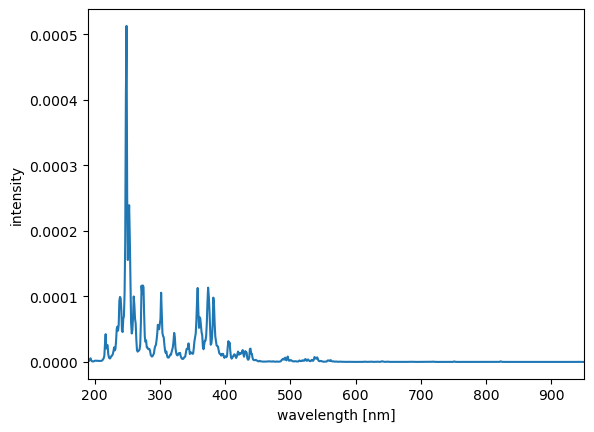

In [8]:
test_maker = spectrum_maker()
#test_maker.peak_maker('Fe', plot=True) #takes 27 sec!
wave, spec = test_maker.peak_maker('Fe', inc=1, plot=True) #takes 1.6 sec
#Time for 

In [15]:
np.sum(spec)

0.009456361742413568

In [50]:

# https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset
class RandomSpectrumDataset(IterableDataset):
    def __init__(self, lowTemp, highTemp, tempInc, n_el):
        super(RandomSpectrumDataset).__init__()
        assert highTemp > lowTemp, "high temp must be greater than low temp"
        self.lowTemp = lowTemp
        self.highTemp = highTemp
        self.tempInc = tempInc
        self.maker = spectrum_maker()
        self.temps = range(lowTemp, highTemp + 1, tempInc)
        #random generator
        self.rng = np.random.default_rng()
        self.n_el = n_el
        
    def __next__(self):
        samp_temp = self.rng.choice(self.temps, 1)
        fracs = np.zeros(self.maker.max_z)
        el_ind = self.rng.choice(range(self.maker.max_z), self.n_el)
        fracs[el_ind] = self.rng.random(self.n_el)
        fracs /= np.sum(fracs) #fractions sum to 1
        wave, spec, spec_array = self.maker.make_spectra(fracs, inc=1, temp=samp_temp)
        x_data = 1000*torch.tensor(spec[None,:].astype('float32'))
        y_data = 1000*torch.tensor(spec_array.astype('float32'))

        return (x_data, y_data)

    def __iter__(self):
        return self

In [51]:
#test the dataset with a DataLoader
test_ds = RandomSpectrumDataset(lowTemp=10000, highTemp=20000, tempInc=100, n_el=4)
test_loader = DataLoader(test_ds, batch_size=20)

In [52]:
#generate data
test_data = {}
for batch, data in enumerate(test_loader):
    test_data[batch] = data
    if batch > 5:
        break


In [59]:
test_data[0][1].shape

torch.Size([20, 94, 782])

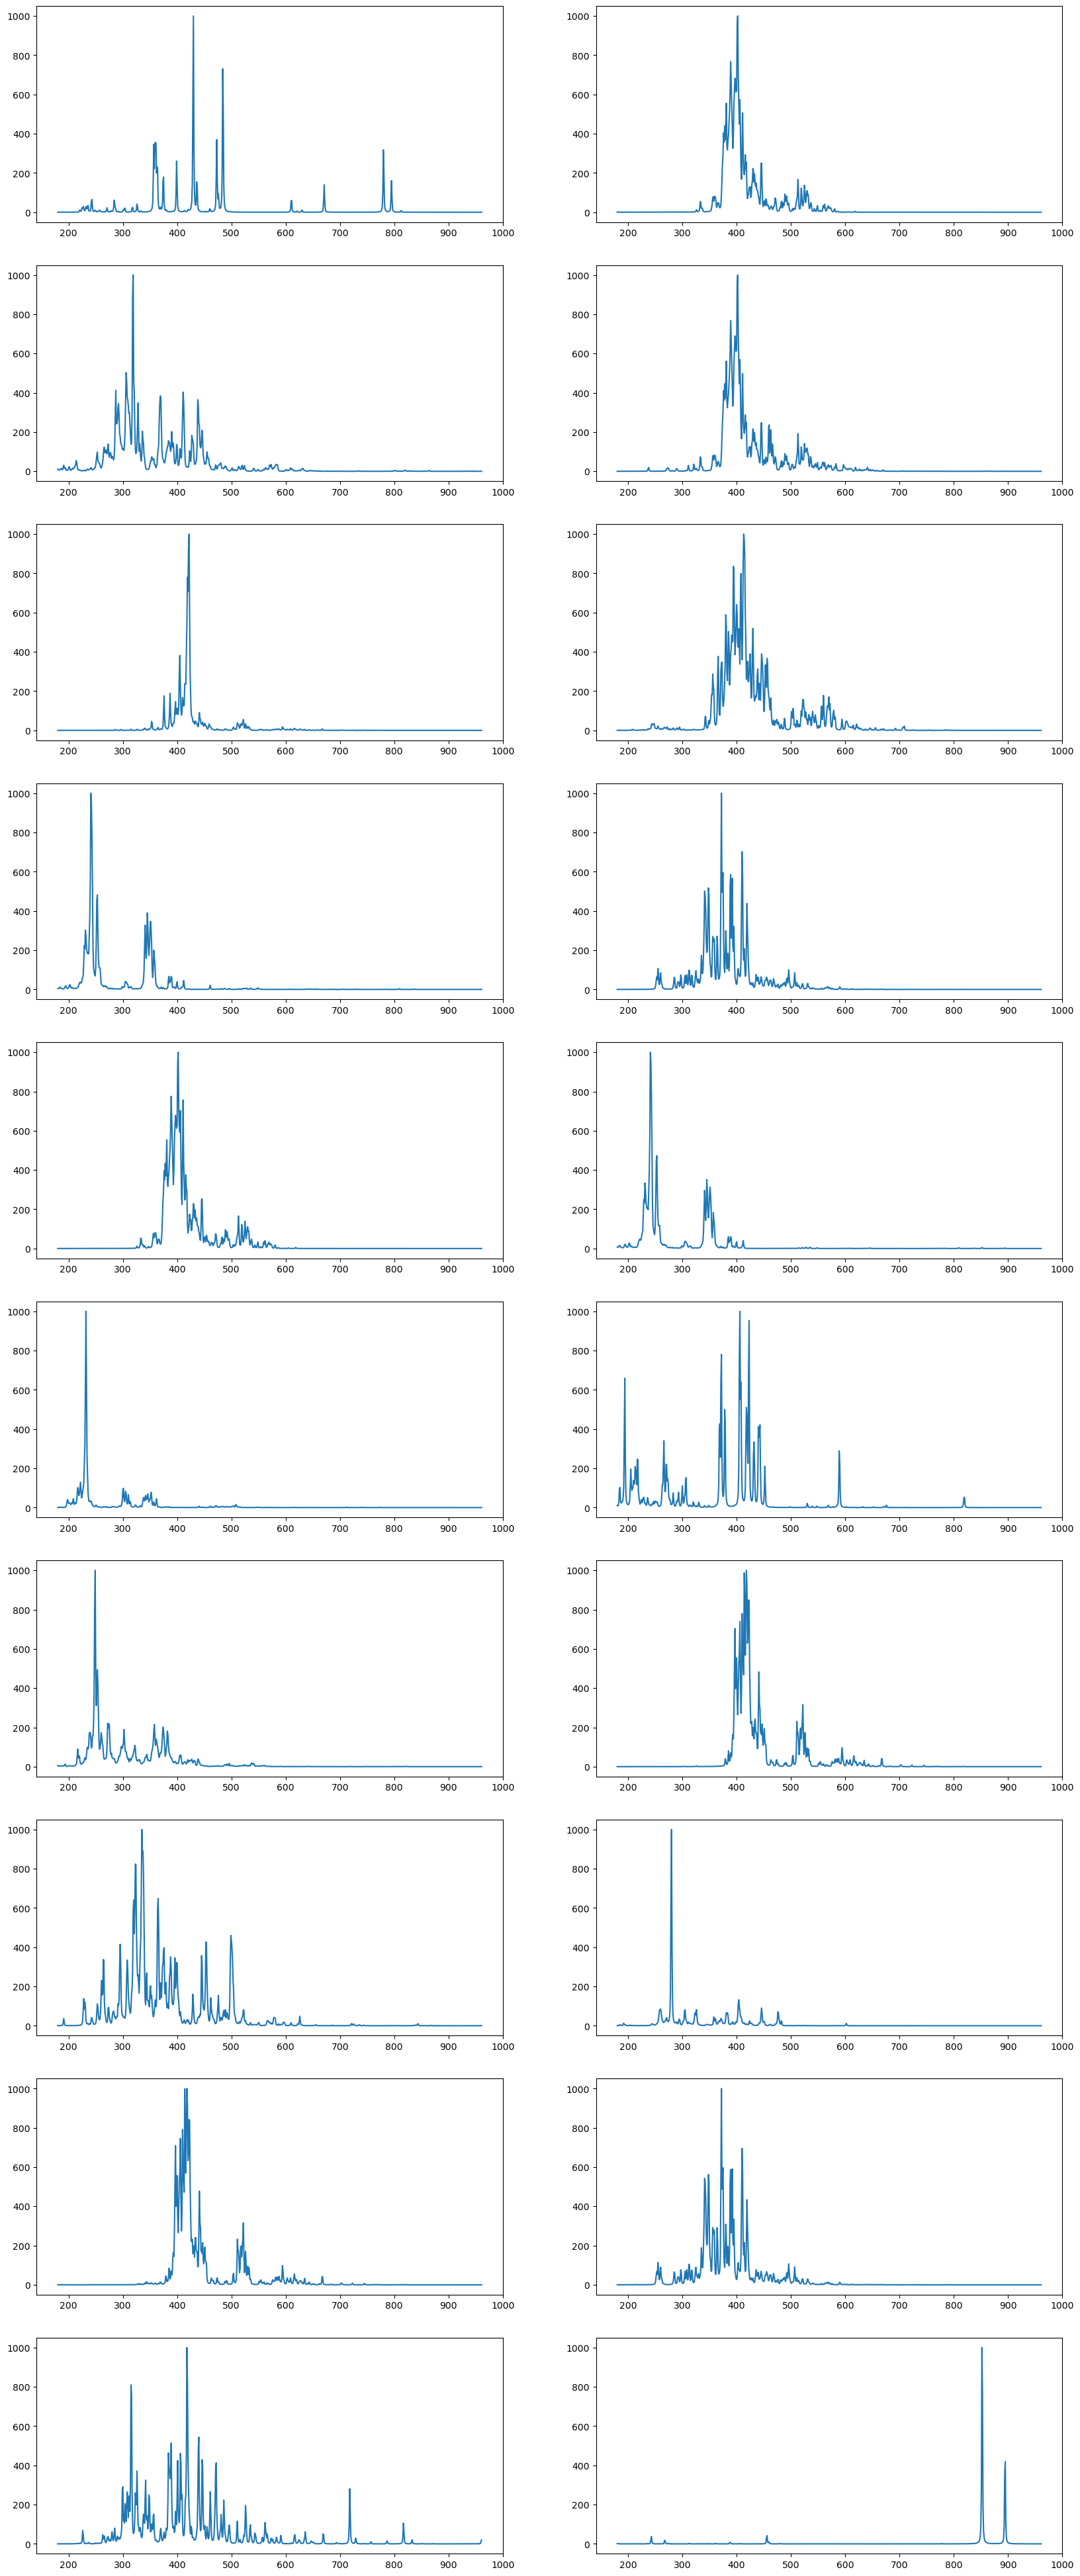

In [62]:
#check output form dataloader, we see relative peak height variation
fig, axs = plt.subplots(10,2, figsize=(20,50))
for i in range(20):
    axs[i // 2][i % 2].plot(wave, test_data[0][0][i].squeeze())

## PeakyFinder 
### optionally, load on GPU

In [63]:


#device = torch.device("mps")
device = torch.device("cpu")

In [64]:
#Initialize model for training
ref_maker = spectrum_maker()
max_z = ref_maker.max_z
wave, spec = ref_maker.peak_maker('Li', inc=1)
wl_points = len(wave) #number of wavelength point measurements in data
model = peakyfinder_0006.LIBSUNet(max_z, wl_points).to(device)

In [67]:
#We are training on infinite generated data now
#Getting errors with data loader workers, need to fix to avoid delay
train_ds = RandomSpectrumDataset(lowTemp=10000, highTemp=20000, tempInc=100, n_el=4)
train_bs = 100
train_dl = DataLoader(test_ds, batch_size=train_bs)

In [68]:
#define tensorboard difference function
def state_diff(new_param, init_wts):

    """ Function to evaluate changes to tunable model parameters during training.
        Arguments:
            new_param: current named_parameters() iter
            init_wts: prior weights as dict
            
        Returns:
            model: dict with same key structure as inputs, with dict of results
                {node1: {wt_norm:123, wt_var:456, wt_mad:23, grad_norm:123}}
                
    """
    
    results_dict = {}

    #iterators can only be traversed once so transform to dict
    new_dict = {}
    for k, v in new_param:
        new_dict[k] = { 'wt':v, 'grad':v.grad }

    #calculate the corresponding dictionary of element-wise wt changes
    diff_dict = {}
    for k,v in new_dict.items():
        diff_dict[k] = v['wt'] - init_wts[k]
    #process node by node in the model
    for k, v in new_dict.items(): 
        #don't process the counters for batchnorm nodes
        if v['wt'].dtype != torch.int64:
            results_dict[k] = {}
            results_dict[k]['wt_mav'] = torch.mean(torch.abs(v['wt']))
            results_dict[k]['wt_var'] = torch.var(v['wt'])
            results_dict[k]['wtdiff_mav'] = torch.mean(torch.abs(diff_dict[k]))
            results_dict[k]['grad_mav'] = torch.mean(torch.abs(v['grad']))
            
    return results_dict

In [70]:
# We don't have epochs in this case as training data is unlimited
max_samples = 1000 #we just stop training here
log_interval = 100
debug = True
loss_fn = nn.MSELoss(reduction='mean')
learning_rate = 0.1 #probably plateau-style update makes most sense, skip for now
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#lr_scheduler = MultiStepLR(optimizer, [50,100,150,200,250,300,350,400,450,500], 0.5)
now_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S') #timestamp string
writerpath = datapath / 'runs' / now_time
writer = SummaryWriter(writerpath)

#training logic
sample_count = 0
init_wts = {}
for k, v in model.named_parameters():
    init_wts[k] = v.clone() #v is a Parameter. Clone is detached tensor

model.train()
for batch, (x, y) in enumerate(train_dl):
    sample_count += train_bs
    # Compute prediction and loss
    pred = model(x)
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #leverages tensor gradients from backward()

    if sample_count  % log_interval == 0: #write to tensorboard
        loss, current = loss.item(), sample_count
        writer.add_scalar("Loss/train", loss, current)
        #detailed logging on nodes info for debug=True
        if debug == True:
            #returns a dictionary node:tensor (3x3) new/old/diff with meanabsval, range, var
            update_dict = state_diff(model.named_parameters(), init_wts)
            for key, value in update_dict.items():
                writer.add_scalars(key, value, sample_count)
            
            #store model dictionary parameter state to compare against with next check            
            for k, v in model.named_parameters():
                init_wts[k] = v.clone()
    
    if sample_count >= max_samples:
        break

print("training completed, remember to save model if desired")

#cleanup
writer.flush()
writer.close()

training completed, remember to save model if desired


In [36]:
#Save model parameters
#param_path = datapath / 'trained_models' / f'earthabund_50k_{now_time}.mdl' #save model with timestamp from when (last round of) training began
#torch.save(model.cpu().state_dict(), param_path)